# Cats and Dogs image classification

- Import all the required Libraries

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
# import tensorflow_hub as hub

##### Seperating cats and dogs images to separate folders

- cat picutres to cat folder
- dog pictures to dog folder
- than copy them and paste it inside 'data' folder
- delete the 'train folder'

In [2]:
# Note!!! This code is used to seperate the images of cats and dogs

# We sort the files into categories by checking the file name

# import re

# def labeler(value):
#     cat_or_dog=re.findall('\w{3}',value)[0].lower()
#     if cat_or_dog=='dog':
#         return 1
#     elif cat_or_dog=='cat':
#         return 0
#     else:
#         return None

# labels=list(map(labeler,file_items))
# # making separate directories for cat and dog
# os.mkdir(f'{train_path}dogs')
# os.mkdir(f'{train_path}cats')


# df_dc=pd.DataFrame([file_items,labels],['file','label'])
# df_dc=df_dc.transpose()
# df_dc.iloc[3]['label']
# train_df=df_dc.iloc[:-6250] 

# # copying the images to their directories

# #train_directory
# cat_train=f'{train_path}cats/'
# dog_train=f'{train_path}dogs/'


# def change_dir_train(value):
#     if value.label==0:
#         os.rename(f'{train_path}{value.file}',f'{cat_train}{value.file}')
#     elif value.label==1:
#         os.rename(f'{train_path}{value.file}',f'{dog_train}{value.file}')
        
# #send to directory
# train_df.apply(change_dir_train,axis=1)

##### Set all the Constants 

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [4]:
# Now loading the separated dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1260 files belonging to 2 classes.


In [5]:
# let see the class names
class_names = dataset.class_names
class_names

['cats', 'dogs']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

#### Visualize some of the images from our dataset again

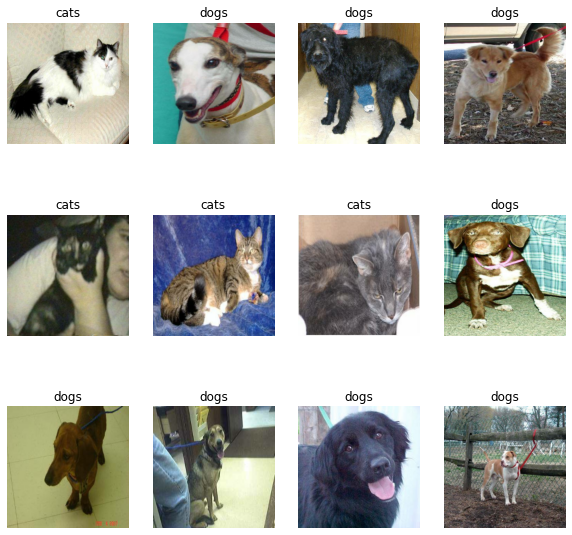

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)

40

In [9]:
train_size = 0.8
len(dataset)*train_size

32.0

In [10]:
train_ds = dataset.take(54)
len(train_ds)

40

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

4.0

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Cache, Shuffle, and Prefetch the Dataset

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation¶
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data. 

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation. 

In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

# Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
32/32 [==============================] - 73s 2s/step - loss: 0.7816 - accuracy: 0.4990 - val_loss: 0.7062 - val_accuracy: 0.4688
Epoch 2/100
32/32 [==============================] - 61s 2s/step - loss: 0.7036 - accuracy: 0.4960 - val_loss: 0.6971 - val_accuracy: 0.5078
Epoch 3/100
32/32 [==============================] - 58s 2s/step - loss: 0.6953 - accuracy: 0.5339 - val_loss: 0.6942 - val_accuracy: 0.5234
Epoch 4/100
32/32 [==============================] - 60s 2s/step - loss: 0.6936 - accuracy: 0.5299 - val_loss: 0.6887 - val_accuracy: 0.5156
Epoch 5/100
32/32 [==============================] - 67s 2s/step - loss: 0.6876 - accuracy: 0.5388 - val_loss: 0.7129 - val_accuracy: 0.5234
Epoch 6/100
32/32 [==============================] - 71s 2s/step - loss: 0.6963 - accuracy: 0.5309 - val_loss: 0.6847 - val_accuracy: 0.5469
Epoch 7/100
32/32 [==============================] - 67s 2s/step - loss: 0.6883 - accuracy: 0.5518 - val_loss: 0.6715 - val_accuracy: 0.5781
Epoch 8/100
3

Epoch 59/100
32/32 [==============================] - 65s 2s/step - loss: 0.4353 - accuracy: 0.7888 - val_loss: 0.4344 - val_accuracy: 0.8125
Epoch 60/100
32/32 [==============================] - 68s 2s/step - loss: 0.4125 - accuracy: 0.8018 - val_loss: 0.3971 - val_accuracy: 0.8438
Epoch 61/100
32/32 [==============================] - 65s 2s/step - loss: 0.4228 - accuracy: 0.8008 - val_loss: 0.4045 - val_accuracy: 0.8281
Epoch 62/100
32/32 [==============================] - 72s 2s/step - loss: 0.3989 - accuracy: 0.8018 - val_loss: 0.4412 - val_accuracy: 0.7969
Epoch 63/100
32/32 [==============================] - 74s 2s/step - loss: 0.4050 - accuracy: 0.8108 - val_loss: 0.3945 - val_accuracy: 0.8125
Epoch 64/100
32/32 [==============================] - 65s 2s/step - loss: 0.3980 - accuracy: 0.8277 - val_loss: 0.3511 - val_accuracy: 0.8516
Epoch 65/100
32/32 [==============================] - 65s 2s/step - loss: 0.3959 - accuracy: 0.8267 - val_loss: 0.3852 - val_accuracy: 0.8438
Epoch 

In [25]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 3s 434ms/step - loss: 0.2889 - accuracy: 0.8516


# Plotting the Accuracy and Loss Curves

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 32}

# loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])

100

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.7816154360771179,
 0.7035632729530334,
 0.6952870488166809,
 0.6935830116271973,
 0.6875962615013123]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

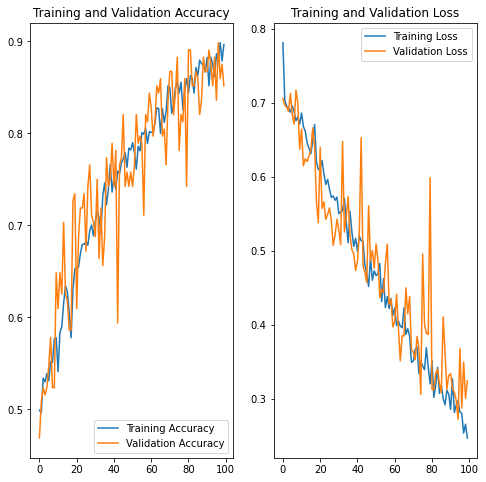

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: dogs
predicted label: dogs


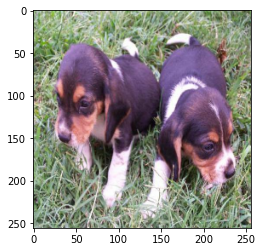

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference


In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Now run inference on few sample images

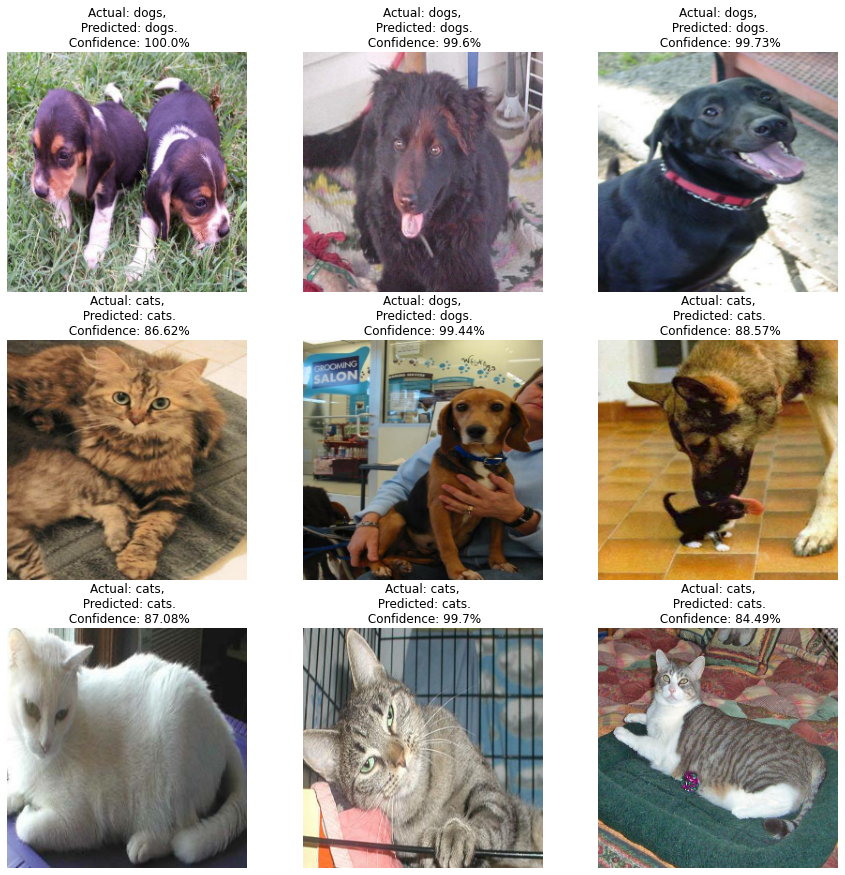

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")